<a href="https://colab.research.google.com/github/shreyashrawat/Fashion_CDCGAN/blob/master/Fashion_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_data():
  (X_train, y_train), (_,_) = keras.datasets.fashion_mnist.load_data()
  X_train = np.expand_dims(X_train, -1)
  X_train = (X_train - 127.5)/127.5
  return [X_train, y_train] 

In [3]:
data = load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
len(data[0])

60000

In [0]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Reshape, LeakyReLU, Embedding, Concatenate, Flatten, Dropout
from keras.models import Model

In [0]:
def discriminator(inp_shape = (28,28,1 ), n_classes = 10):
  in_label = Input(shape = (1,))
  li = Embedding(input_dim= n_classes, output_dim = 50)(in_label)
  n_nodes = inp_shape[0] * inp_shape[1]
  li = Dense(n_nodes)(li)
  li = Reshape(target_shape=(inp_shape[0], inp_shape[1],1))(li)
  in_image = Input(shape = inp_shape)
  merge = Concatenate()([in_image, li])
  ds = Conv2D(128, (4,4), strides = (2,2), padding = "same")(merge)
  ds = LeakyReLU(0.2)(ds)
  ds = Conv2D(128, (4,4), strides = (2,2), padding = "same")(ds)
  ds = LeakyReLU(0.2)(ds)

  ds = Flatten()(ds)
  ds = Dropout(0.4)(ds)

  out_layer = Dense(1, activation = "sigmoid")(ds)

  model = Model([in_image, in_label], out_layer)
  model.compile(optimizer = keras.optimizers.Adam(0.0002, beta_1 = 0.5), loss = "binary_crossentropy", metrics = ['acc'])
  return model

In [0]:
d_model = discriminator()

In [8]:
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
____________________________________________________________________________________________

In [0]:
def generator(latent_dim = 100, n_classes = 10):
  in_label = Input(shape = (1,))
  gl = Embedding(input_dim = n_classes, output_dim = 50)(in_label)

  n_nodes = 7 * 7
  gl = Dense(n_nodes)(gl)
  gl = Reshape((7,7,1))(gl)

  in_lat = Input(shape = (latent_dim,))
  ls = Dense(7 * 7 * 128)(in_lat)
  ls = LeakyReLU(0.2)(ls)
  ls = Reshape((7,7,128))(ls)

  merge = Concatenate()([ls, gl])

  gen = Conv2DTranspose(128, 4, strides=(2,2), padding = "same")(merge)
  gen = LeakyReLU(0.2)(gen)

  gen = Conv2DTranspose(128, 4, strides=(2,2), padding = "same")(gen)
  gen = LeakyReLU(0.2)(gen)

  output_layer = Conv2D(1, 7, padding="same", activation = "tanh")(gen)

  model = Model([in_lat, in_label], output_layer)
  return model



In [0]:
g_model = generator()

In [0]:
def gan(g_model, d_model):
  d_model.trainable = False
  gen_noise, gen_label = g_model.input
  gen_output = g_model.output
  gan_output = d_model([gen_output, gen_label])
  model = Model([gen_noise, gen_label], gan_output)
  model.compile(optimizer = keras.optimizers.Adam(0.0002, beta_1 = 0.5), loss = "binary_crossentropy")
  return model

In [0]:
gan_model = gan(g_model, d_model)

In [13]:
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
def generate_real_samples(dataset, n_samples):
  ind = np.random.randint(0, len(dataset[0]), n_samples)
  img, labels = dataset
  X, labels = img[ind], labels[ind]
  y = np.ones((n_samples, 1))
  return [X,labels], y

In [0]:
def generate_latent_space(n_size = 128, latent_dim = 100, n_classes = 10):
  points = np.random.randn(n_size * latent_dim)
  points = points.reshape((n_size, latent_dim))
  y = np.random.randint(0, n_classes, n_size )
  return points, y

In [0]:
def generate_fake_examples(g_model, n_size = 128):
  points, label_inp = generate_latent_space()
  images = g_model.predict([points, label_inp])
  y = np.zeros((n_size, 1))
  return [images, label_inp], y

In [0]:
def train(g_model, d_model, gan_model, dataset, n_size = 128, epochs = 70, latent_dim = 100):
  batch_per_epoch = int(dataset[0].shape[0]/n_size)
  half_batch = int(n_size/2)
  for i in range(epochs):
    for j in range(batch_per_epoch):
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

      [x_fake, labels], y_fake = generate_fake_examples(g_model)
      d_loss2, _ = d_model.train_on_batch([x_fake, labels], y_fake)

      [z_input, labels_input] = generate_latent_space()
      y_gan = np.ones((n_size, 1))

      gan_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      if((j+1)%50 == 0):
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				  (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, gan_loss))
    # if((i+1) % 10 == 0):
    #   summarize_performance()

In [18]:
train(g_model, d_model, gan_model, data)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


>1, 50/468, d1=0.101, d2=0.748 g=0.736
>1, 100/468, d1=0.733, d2=0.464 g=1.406
>1, 150/468, d1=0.495, d2=0.807 g=0.773
>1, 200/468, d1=0.663, d2=0.760 g=0.809
>1, 250/468, d1=0.612, d2=0.694 g=0.783
>1, 300/468, d1=0.635, d2=0.604 g=0.885
>1, 350/468, d1=0.632, d2=0.657 g=0.833
>1, 400/468, d1=0.602, d2=0.707 g=0.750
>1, 450/468, d1=0.623, d2=0.643 g=0.871
>2, 50/468, d1=0.578, d2=0.657 g=0.857
>2, 100/468, d1=0.537, d2=0.600 g=0.963
>2, 150/468, d1=0.579, d2=0.568 g=1.060
>2, 200/468, d1=0.624, d2=0.694 g=0.829
>2, 250/468, d1=0.671, d2=0.514 g=1.061
>2, 300/468, d1=0.716, d2=0.817 g=0.678
>2, 350/468, d1=0.689, d2=0.661 g=0.809
>2, 400/468, d1=0.626, d2=0.650 g=0.857
>2, 450/468, d1=0.578, d2=0.640 g=0.815
>3, 50/468, d1=0.641, d2=0.624 g=0.842
>3, 100/468, d1=0.608, d2=0.666 g=0.813
>3, 150/468, d1=0.624, d2=0.634 g=0.888
>3, 200/468, d1=0.609, d2=0.598 g=0.837
>3, 250/468, d1=0.573, d2=0.596 g=0.903
>3, 300/468, d1=0.597, d2=0.600 g=0.909
>3, 350/468, d1=0.630, d2=0.663 g=0.846
>3,

In [0]:
g_model.save('cgan_generator.h5')

In [0]:
def save_plot(examples):
  plt.figure(figsize = (15,15))
  for i in range(10*10):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(examples[i,:,:,0], cmap = "gray_r")
  plt.show()


In [32]:
model = keras.models.load_model("cgan_generator.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
latent_points, labels = generate_latent_space(100,100)

In [23]:
labels

array([9, 1, 2, 2, 9, 7, 8, 4, 2, 6, 5, 0, 3, 7, 4, 6, 6, 3, 6, 3, 6, 3,
       8, 0, 6, 3, 8, 9, 1, 8, 0, 6, 6, 9, 8, 7, 2, 8, 6, 3, 1, 1, 9, 4,
       5, 5, 3, 4, 1, 7, 8, 8, 9, 9, 7, 7, 3, 3, 6, 4, 1, 7, 1, 3, 9, 7,
       7, 3, 1, 3, 1, 4, 8, 2, 1, 5, 4, 1, 5, 8, 1, 3, 7, 7, 7, 5, 6, 6,
       5, 4, 9, 5, 5, 1, 1, 9, 2, 8, 2, 9])

In [0]:
labels = np.asarray([x for _ in range(10) for x in range(10)])

In [34]:
labels

array([2, 7, 1, 5, 4, 3, 3, 3, 7, 8, 4, 5, 7, 8, 9, 2, 9, 1, 9, 0, 7, 9,
       7, 7, 1, 9, 1, 4, 5, 3, 4, 9, 9, 0, 2, 8, 9, 3, 8, 3, 8, 5, 5, 2,
       0, 6, 1, 7, 2, 2, 1, 9, 0, 1, 8, 0, 1, 1, 9, 7, 7, 2, 0, 0, 4, 2,
       3, 3, 3, 9, 3, 6, 2, 1, 5, 2, 8, 5, 4, 6, 5, 2, 7, 7, 3, 9, 2, 1,
       3, 5, 1, 7, 7, 3, 6, 8, 4, 6, 9, 5])

In [0]:
X = model.predict([latent_points, labels])

In [42]:
X.shape

(100, 28, 28, 1)

In [0]:
X = (X+1)/2.0

In [38]:
X.shape

(100, 28, 28, 1)

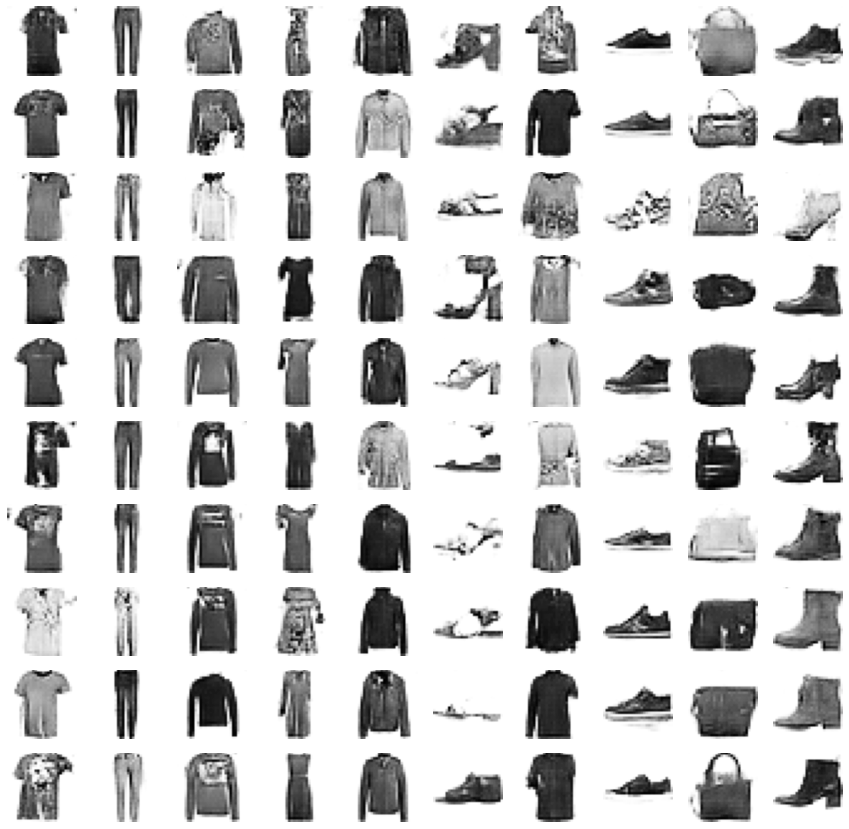

In [44]:
save_plot(X)